In [8]:
import pandas as pd
import geopandas as gpd

sensor4_data = gpd.read_file("../code/results/output/9fdfc3b9/sensor_10_shade_added.geojson")

In [9]:
sensor4_data['Globe Temperature'] = sensor4_data['Globe Temperature'].astype('float64')

In [10]:
sensor4_data['FORMATTED DATE_TIME'] = pd.to_datetime(sensor4_data['FORMATTED DATE_TIME'])

In [11]:
sensor4_data['building_shade'].unique()

array([0., 1.])

C:\Users\Dila Ozberkman\AppData\Local\Temp\ipykernel_26852\46728767.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly_ticks = sensor4_data['FORMATTED DATE_TIME'].dt.floor('H').drop_duplicates()


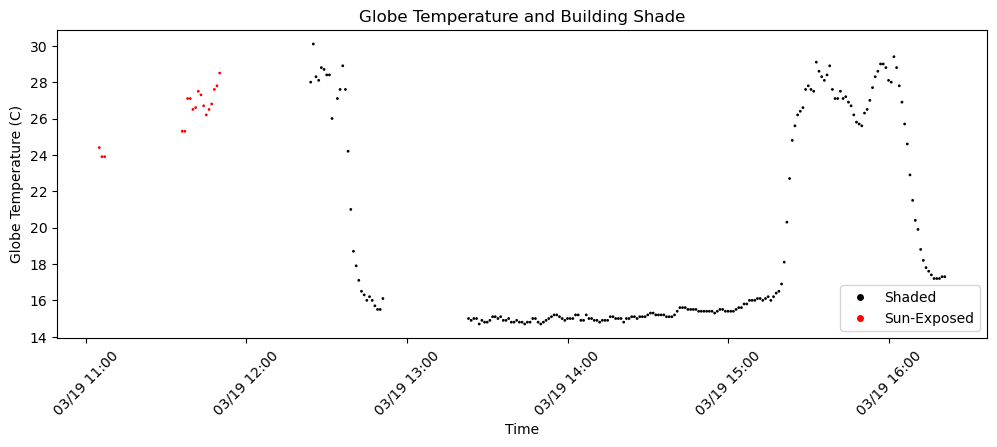

In [12]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.figure(figsize=(12, 4))

# Color points red if spike, gray otherwise
colors = sensor4_data['building_shade'].round(2).map({1.0: 'black', 0.9: 'grey', 0.0: 'red'})

# Assign the scatter plot to a variable so we can use it for the colorbar
sc = plt.scatter(
    sensor4_data['FORMATTED DATE_TIME'],
    sensor4_data['Globe Temperature'],
    s=1,
    c=colors
)

# Add simple legend using proxy handles
plt.legend(
    handles=[
        plt.Line2D([0], [0], marker='o', color='w', label='Shaded', markerfacecolor='black', markersize=6),
        plt.Line2D([0], [0], marker='o', color='w', label='Sun-Exposed', markerfacecolor='red', markersize=6)
    ],
    loc='lower right'
)

# Round timestamps to nearest hour, drop duplicates
hourly_ticks = sensor4_data['FORMATTED DATE_TIME'].dt.floor('H').drop_duplicates()

plt.xticks(ticks=hourly_ticks, rotation=45)

ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d %H:%M'))

# You can skip plt.legend() unless you have manually added labeled plots
plt.xlabel('Time')
plt.ylabel('Globe Temperature (C)')
plt.title('Globe Temperature and Building Shade')
plt.show()

In [40]:
import rasterio
import imageio
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import numpy as np
import os
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas

def create_shade_gif(
    shade_tif_paths,
    shade_data,
    sensor_id,
    gif_path,
    pixel_buffer_m=50
):

    frames = []

    with rasterio.open(shade_tif_paths[0]) as ref_src:
        transform = ref_src.transform
        crs = ref_src.crs
        res_x, res_y = ref_src.res

    sensor_row = shade_data.iloc[0] if sensor_id is None else shade_data[shade_data['sensorid'] == sensor_id].iloc[0]
    sensor_point = sensor_row.geometry
    sensor_x, sensor_y = sensor_point.x, sensor_point.y

    pixel_buffer = int(pixel_buffer_m / res_x)
    center_row, center_col = rasterio.transform.rowcol(transform, sensor_x, sensor_y)

    for tif_path in shade_tif_paths:
        # Extract timestamp from filename like: '9fdfc3b9_p_0_Shadow_20250319_1045_LST.tif'
        fname = os.path.basename(tif_path)
        parts = fname.split('_')
        timestamp_str = parts[-3] + parts[-2]  # e.g., '20250319' + '1045'
        timestamp = pd.to_datetime(timestamp_str, format='%Y%m%d%H%M')

        sensor_match = shade_data[shade_data['FORMATTED DATE_TIME'] == timestamp]
        if sensor_match.empty:
            continue
        is_shaded = sensor_match['building_shade'].values[0] == 1.0

        with rasterio.open(tif_path) as src:
            shade_data_raster = src.read(1)

            row_start = max(center_row - pixel_buffer, 0)
            row_end = min(center_row + pixel_buffer, shade_data_raster.shape[0])
            col_start = max(center_col - pixel_buffer, 0)
            col_end = min(center_col + pixel_buffer, shade_data_raster.shape[1])

            window = shade_data_raster[row_start:row_end, col_start:col_end]

            fig, ax = plt.subplots(figsize=(4, 4))
            extent = [
                sensor_x - pixel_buffer_m,
                sensor_x + pixel_buffer_m,
                sensor_y - pixel_buffer_m,
                sensor_y + pixel_buffer_m
            ]
            ax.imshow(window, cmap='Greys', extent=extent, origin='upper', vmin=0, vmax=1)

            ax.scatter(
                sensor_x, sensor_y,
                color='blue' if is_shaded else 'red',
                s=30,
                edgecolor='white',
                linewidth=0.7
            )

            ax.legend(
                handles=[
                    plt.Line2D([0], [0], marker='o', color='w', label='Shaded', markerfacecolor='blue', markersize=8),
                    plt.Line2D([0], [0], marker='o', color='w', label='Sun-Exposed', markerfacecolor='red', markersize=8)
                ],
                loc='upper right'
            )

            ax.set_title(timestamp.strftime('%m/%d %H:%M'))
            ax.set_xticks([])
            ax.set_yticks([])

            canvas = FigureCanvas(fig)
            canvas.draw()

            frame = np.frombuffer(canvas.buffer_rgba(), dtype=np.uint8)
            frame = frame.reshape(canvas.get_width_height()[::-1] + (4,))
            frame = frame[:, :, :3]  # drop alpha channel to make it RGB

            frames.append(frame)
            plt.close(fig)

    imageio.mimsave(gif_path, frames, fps=2)

In [41]:
shade_tifs = sorted(
    [os.path.join('../code/results/output/9fdfc3b9/building_shade/0', f) for f in os.listdir('../code/results/output/9fdfc3b9/building_shade/0') if "_LST.tif" in f],
    key=lambda f: pd.to_datetime(f.split('_')[-3] + f.split('_')[-2], format='%Y%m%d%H%M')
)

create_shade_gif(
    shade_tif_paths=shade_tifs,
    shade_data=sensor4_data,  # your joined DataFrame with sensor readings + 'building_shade'
    sensor_id=None,           # or set this to filter by sensor if needed
    gif_path='sensor4_shade.gif'
)

In [6]:
sensor10_data = gpd.read_file("../code/results/output/9fdfc3b9/sensor_10_shade_added.geojson")
sensor4_data = gpd.read_file("../code/results/output/9fdfc3b9/sensor_4_shade_added.geojson")
sensor8_data = gpd.read_file("../code/results/output/9fdfc3b9/sensor_8_shade_added.geojson")

DataSourceError: ../code/results/output/9fdfc3b9/sensor_8_shade_added.geojson: No such file or directory

In [ ]:
sensor_data = pd.concat([sensor4_data, sensor8_data, sensor10_data], axis=0, ignore_index=True)

In [ ]:
sensor_data['FORMATTED DATE_TIME'] = pd.to_datetime(sensor_data['FORMATTED DATE_TIME'])

In [7]:
def get_interval_stamp(timestamp, interval=30):
    """
    Given a datetime object representing the timestamp for a day,
    return a new datetime object for the nearest interval boundary (in minutes)
    to that timestamp. The calculation assumes the day starts at 00:00.
    """
    minutes_since_midnight = timestamp.hour * 60 + timestamp.minute
    rounded_minutes = round(minutes_since_midnight / interval) * interval
    r_hour = rounded_minutes // 60
    r_minute = rounded_minutes % 60

    return timestamp.replace(hour=r_hour, minute=r_minute, second=0, microsecond=0)

# Apply correct rounding to nearest interval
sensor_data["rounded_timestamp"] = sensor_data['FORMATTED DATE_TIME'].apply(lambda x: get_interval_stamp(x, 15))

NameError: name 'sensor_data' is not defined

In [13]:
import os
import re
import rasterio
import numpy as np
import imageio
from PIL import Image, ImageDraw
import pandas as pd
from shapely.geometry import Point

# Inputs
base_path = "../code/results/output/9fdfc3b9/building_shade/0"
output_gif_path = "../code/results/output/visuals/9fdfc3b9/shade_sensor_data.gif"

# Assume you have this as your sensor data GeoDataFrame:
# - geometry column with Point(x, y)
# - FORMATTED DATE_TIME column
# - building_shade (1=shaded, 0=sun)

sensor_data.to_crs("EPSG:32631", inplace=True)  # now reproject to match raster

# Regular expression to extract timestamp from filename
pattern = re.compile(r".*_(\d{8})_(\d{4})_LST\.tif")

# Get list of valid .tif files
frame_files = []
for filename in os.listdir(base_path):
    if filename.endswith(".tif") and not filename.endswith(".tif.ovr"):
        match = pattern.match(filename)
        if match:
            frame_files.append(os.path.join(base_path, filename))

# Sort files by timestamp extracted from filename
frame_files.sort()

# List to hold frames
frames = []

for tif_file in frame_files:
    match = pattern.match(os.path.basename(tif_file))
    if not match:
        continue

    timestamp_str = match.group(1) + match.group(2)  # e.g. '20250319' + '1045'
    timestamp = pd.to_datetime(timestamp_str, format="%Y%m%d%H%M")

    with rasterio.open(tif_file) as src:
        data = src.read(1)
        transform = src.transform
        width, height = src.width, src.height

        # 1. Get raster center
        center_col = width // 2
        center_row = height // 2

        # 2. Define crop box: 400x400 centered
        crop_size = 400
        half_crop = crop_size // 2
        row_start = max(center_row - half_crop, 0)
        row_end = min(center_row + half_crop, height)
        col_start = max(center_col - half_crop, 0)
        col_end = min(center_col + half_crop, width)

        # 3. Crop the data
        data_cropped = data[row_start:row_end, col_start:col_end]

        # 4. Normalize (safeguard against division by 0)
        if np.max(data_cropped) == np.min(data_cropped):
            img_array = np.zeros_like(data_cropped, dtype=np.uint8)
        else:
            norm = ((data_cropped - np.min(data_cropped)) / (np.max(data_cropped) - np.min(data_cropped))) * 255
            img_array = norm.astype(np.uint8)

        # 5. Create image and draw object
        img = Image.fromarray(img_array).convert("RGB")
        draw = ImageDraw.Draw(img)

        # Select sensor values at current timestamp
        matched_sensors = sensor_data[sensor_data["rounded_timestamp"] == timestamp]

        for _, row in matched_sensors.iterrows():
            point = row.geometry
            x, y = point.x, point.y

            # Get pixel coords from geographic coords
            col_pix, row_pix = rasterio.transform.rowcol(transform, x, y)

            col_pix, row_pix = rasterio.transform.rowcol(transform, x, y)

            # Check if the point is inside the crop
            if row_start <= row_pix < row_end and col_start <= col_pix < col_end:
                # Shift coordinates to cropped window
                col_in_crop = col_pix - col_start
                row_in_crop = row_pix - row_start

                radius = 5
                color = "red"
                draw.ellipse([
                    (col_in_crop - radius, row_in_crop - radius),
                    (col_in_crop + radius, row_in_crop + radius)
                ], fill=color, outline="white")

            frames.append(img)

# Save the GIF
frames[0].save(output_gif_path, save_all=True, append_images=frames[1:], duration=15, loop=1)

print(f"GIF saved at: {output_gif_path}")


GIF saved at: ../code/results/output/visuals/9fdfc3b9/shade_sensor_data.gif
